In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import svm
from sklearn.metrics import classification_report
import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from sklearn import metrics as metricssk
import math

## Reading the data

In [2]:
# Read the csv with all the extracted data (pylidc and radiomic features combined)
df = pd.read_csv("DADOSTODOS.csv")
testdf = df.copy(deep=True)

## Fix for a global id per nodule and a simpler patient ID

converting Patient_ID into an integer value and introducing a global "Nodule_ID" so that we can group annotations into their respective nodules

In [3]:
id = 1
node_id = []
pid_list = []

for i in range(len(df)-1):
    node_id.append(id)
    pid_list.append(int(testdf.Patient_ID[i][-4:]))
    if ((testdf.Patient_ID[i] != testdf.Patient_ID[i+1]) or (testdf.Nodule[i] != testdf.Nodule[i+1])):
        id+=1
node_id.append(id)
#pid_list.append(patientid)
pid_list.append(int(testdf.Patient_ID[i][-4:]))

testdf['Nodule_ID'] = node_id
testdf['Patient_ID_int'] = pid_list

## Separate the data into 3 dataframes

- data extracted with pylidc
- data extracted with pyradiomics
- combined data

In [4]:
# Create lists of the relevant columns for the dataframes

pylidc_columns = ['Patient_ID_int','Nodule_ID', 'Subtlety', 'InternalStructure', 'Calcification', 'Sphericity', 'Margin', 'Lobulation', 'Spiculation', 'Texture', 'Malignancy']
pylidc_columns_plus_trash = ['Patient_ID_int', 'Subtlety', 'InternalStructure', 'Calcification', 'Sphericity', 'Margin', 'Lobulation', 'Spiculation', 'Texture', 'Malignancy','Nodule',' Annotation']

In [5]:
# Grab the relevant columns from the pyradiomics extraction, discarding features which are represented by string values

pyradiomics_columns = ['Patient_ID_int']

for column, data in testdf.items():
    if (not (type(data[0]) is str)) and (column not in pylidc_columns_plus_trash):
        pyradiomics_columns.append(column)

In [6]:
# Create 2 of the main dataframes

pyradiomics_df = testdf[pyradiomics_columns]
pylidc_df = testdf[pylidc_columns]

## Treating the data before finalizing the dataframes for further use

We now group the different annotation values into nodules. We must define a metric to group the values and discard nodules which might be problematic.
- Pylidc dataframe: We use the mode for all values to account for the fact that they might not be ordinal, discarding examples where the amplitude of the values is very large
- Pyradiomics dataframe: We use the mean for all values and consider as the label "Malignancy" feature obtained from the pylidc dataframe

In [7]:
# Grouping the annotation values into nodules

pylidc_mode = pylidc_df.groupby('Nodule_ID').agg(lambda x: x.mode().values[0])
pylidc_mode = pylidc_mode[['InternalStructure', 'Calcification']]
pylidc_amp = pylidc_df.groupby('Nodule_ID').agg(lambda x: x.max()-x.min())
pylidc_mean = pylidc_df.groupby('Nodule_ID').mean()
pylidc_mean = pylidc_mean[['Patient_ID_int', 'Subtlety', 'Sphericity', 'Margin', 'Lobulation', 'Spiculation', 'Texture', 'Malignancy']]
pylidc_mean['Patient_ID_int'] = pylidc_mean['Patient_ID_int'].astype(int)

pyradiomics_mean = pyradiomics_df.groupby('Nodule_ID').mean()
pyradiomics_mean['Patient_ID_int'] = pyradiomics_mean['Patient_ID_int'].astype(int)

In [8]:
pylidc_mean.head(5)

,Patient_ID_int,Subtlety,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy
Nodule_ID,,,,,,,,
1,1,5.0,3.75,3.25,3.00,4.25,4.75,4.75
2,2,1.5,4.00,1.50,1.00,1.00,1.50,4.50
3,3,1.0,5.00,2.00,1.00,1.00,1.00,2.00
4,3,5.0,4.00,3.25,2.00,3.00,4.00,4.25
5,3,3.5,3.50,4.00,1.75,1.50,4.75,3.25


In [9]:
pyradiomics_mean.head(5)

,Patient_ID_int,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-corrected_VoxelNum,diagnostics_Mask-corrected_VolumeNum,diagnostics_Mask-corrected_Mean,diagnostics_Mask-corrected_Minimum,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
Nodule_ID,,,,,,,,,,,,,,,,,,,,,
1,1,-826.943929,-2048.0,3071.0,5242.75,1.0,5242.75,1.0,-69.850220,-824.25,...,481.671194,0.003443,6.508549,0.349762,528.647056,0.425589,0.001276,3038.782452,0.310652,1.470182
2,2,-1013.563545,-3024.0,1752.0,11473.00,1.0,11473.00,1.0,-689.735875,-940.00,...,163.622696,0.007584,6.893299,0.145218,1610.761075,1.730337,0.001205,979.567361,0.050911,0.982800
3,3,-802.641978,-2048.0,5892.0,2542.00,1.0,2542.00,1.0,-640.765932,-891.00,...,175.560472,0.013967,6.693464,0.282061,77.874166,0.540909,0.003731,1918.619966,0.090857,4.007826
4,3,-802.641978,-2048.0,5892.0,3569.75,1.0,3569.75,1.0,-192.473453,-719.25,...,261.418127,0.006173,6.367803,0.366863,239.638290,0.507511,0.002129,2163.702032,0.309850,1.480352
5,3,-802.641978,-2048.0,5892.0,231.25,1.0,231.25,1.0,-325.178410,-738.00,...,207.224180,0.028382,5.567437,0.641871,2.727102,0.130484,0.018326,2913.188143,1.062983,6.930827


In [10]:
# Eliminate the rows which have an apmlitude of malignancy greater than 2 on both dataframes

count=0
rownum = 0
all_pylidc = pd.concat([pylidc_mean,pylidc_mode], axis=1)
pylidc = all_pylidc.copy(deep=True)
pyradiomics = pyradiomics_mean.copy(deep=True)
for malign in pylidc_amp['Malignancy']:
    if malign>=2:
        pylidc.drop(rownum,axis=0,inplace=True)
        pyradiomics.drop(rownum,axis=0,inplace=True)
        count+=1
    rownum+=1
print(f"Number of cases eliminated = {count}")

Number of cases eliminated = 732


In [11]:
# Turning the Malignancy feature to a binary feature

binary_malignancy = []
normalized_maligancy = []

for val in pylidc['Malignancy']:
    normalized_maligancy.append((val-1)/5)
    if val>=3:
        binary_malignancy.append(1)
    else:
        binary_malignancy.append(0)

pylidc['Binary_Malignancy'] = binary_malignancy
pylidc['Normalized_Malignancy'] = normalized_maligancy

In [12]:
# Create the final main dataframe
# (before adding labels to the radioics dataframe so that we dont have repeating columns)
pylidc['Malignancy'] = pylidc['Malignancy'].round(0).astype(int)
df_total = pd.concat([pylidc,pyradiomics], axis=1)
df_total = df_total.loc[:,~df_total.columns.duplicated()]

In [13]:
#add labels to the pyradiomics dataset
pyradiomics[['Malignancy', 'Binary_Malignancy','Normalized_Malignancy']] = pylidc[['Malignancy', 'Binary_Malignancy','Normalized_Malignancy']]

In [14]:
pylidc.head(20)

,Patient_ID_int,Subtlety,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy,InternalStructure,Calcification,Binary_Malignancy,Normalized_Malignancy
Nodule_ID,,,,,,,,,,,,
1,1,5.000000,3.75,3.250000,3.00,4.250000,4.75,5,1.0,6.0,1,0.750000
2,2,1.500000,4.00,1.500000,1.00,1.000000,1.50,4,1.0,6.0,1,0.700000
6,3,4.000000,4.50,5.000000,1.00,1.000000,5.00,4,1.0,6.0,1,0.500000
7,4,3.000000,3.50,5.000000,1.00,1.000000,5.00,1,1.0,3.0,0,0.050000
8,5,2.500000,4.75,4.000000,1.00,1.000000,4.75,3,1.0,6.0,0,0.350000
9,5,3.500000,4.50,4.500000,1.25,1.250000,4.75,3,1.0,6.0,0,0.350000
10,5,3.000000,3.00,5.000000,1.00,1.000000,5.00,2,1.0,6.0,0,0.200000
11,6,3.000000,3.00,5.000000,2.00,1.000000,4.00,2,1.0,6.0,0,0.200000
12,6,1.500000,3.00,3.500000,1.50,2.000000,4.00,3,1.0,6.0,1,0.400000


In [15]:
pyradiomics.head(5)

,Patient_ID_int,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-corrected_VoxelNum,diagnostics_Mask-corrected_VolumeNum,diagnostics_Mask-corrected_Mean,diagnostics_Mask-corrected_Minimum,...,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Malignancy,Binary_Malignancy,Normalized_Malignancy
Nodule_ID,,,,,,,,,,,,,,,,,,,,,
1,1,-826.943929,-2048.0,3071.0,5242.75,1.0,5242.75,1.0,-69.850220,-824.25,...,0.349762,528.647056,0.425589,0.001276,3038.782452,0.310652,1.470182,5,1,0.75
2,2,-1013.563545,-3024.0,1752.0,11473.00,1.0,11473.00,1.0,-689.735875,-940.00,...,0.145218,1610.761075,1.730337,0.001205,979.567361,0.050911,0.982800,4,1,0.70
6,3,-802.641978,-2048.0,5892.0,680.25,1.0,680.25,1.0,-220.463713,-851.00,...,0.473935,79.444876,0.150739,0.005417,3097.372586,0.741893,5.336067,4,1,0.50
7,4,-1027.677776,-3024.0,3071.0,77.25,1.0,77.25,1.0,-48.312863,-572.25,...,0.813145,0.529018,0.040072,0.043983,8198.232839,3.443953,55.753183,1,0,0.05
8,5,-795.283116,-2048.0,3071.0,65.75,1.0,65.75,1.0,-496.857740,-707.25,...,0.536288,1.341951,0.130958,0.075435,379.275570,0.536612,9.518361,3,0,0.35


In [16]:
df_total.head(5)

,Patient_ID_int,Subtlety,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy,InternalStructure,Calcification,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
Nodule_ID,,,,,,,,,,,,,,,,,,,,,
1,1,5.0,3.75,3.25,3.0,4.25,4.75,5,1.0,6.0,...,481.671194,0.003443,6.508549,0.349762,528.647056,0.425589,0.001276,3038.782452,0.310652,1.470182
2,2,1.5,4.00,1.50,1.0,1.00,1.50,4,1.0,6.0,...,163.622696,0.007584,6.893299,0.145218,1610.761075,1.730337,0.001205,979.567361,0.050911,0.982800
6,3,4.0,4.50,5.00,1.0,1.00,5.00,4,1.0,6.0,...,382.782209,0.010208,5.791823,0.473935,79.444876,0.150739,0.005417,3097.372586,0.741893,5.336067
7,4,3.0,3.50,5.00,1.0,1.00,5.00,1,1.0,3.0,...,645.979215,0.048912,5.259068,0.813145,0.529018,0.040072,0.043983,8198.232839,3.443953,55.753183
8,5,2.5,4.75,4.00,1.0,1.00,4.75,3,1.0,6.0,...,46.524926,0.058768,4.490178,0.536288,1.341951,0.130958,0.075435,379.275570,0.536612,9.518361


## Analysing the resulting dataframes

Next we empirically analyse data attributes such as the label distribution to determine which learning algorithms will be appropriate for learning this dataset

In [17]:
df_total['Malignancy'].value_counts()

3    729
2    556
4    263
1    201
5     44
Name: Malignancy, dtype: int64

### Histogram

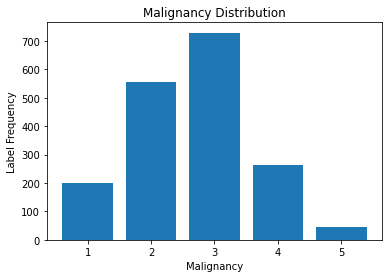

In [18]:
value_counts = df_total['Malignancy'].value_counts().sort_index()
plt.bar(value_counts.index, value_counts.values)

plt.xlabel('Malignancy')
plt.ylabel('Label Frequency')
plt.title('Malignancy Distribution')

plt.show()

### BoxPlot

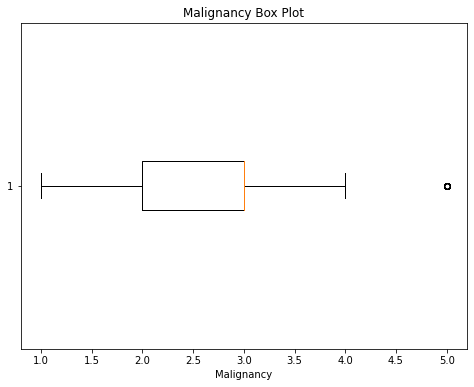

In [19]:
plt.figure(figsize=(8, 6)) 
plt.boxplot(df_total['Malignancy'], vert=False)  
plt.xlabel('Malignancy')
plt.title('Malignancy Box Plot')

plt.show()

### Heatmap

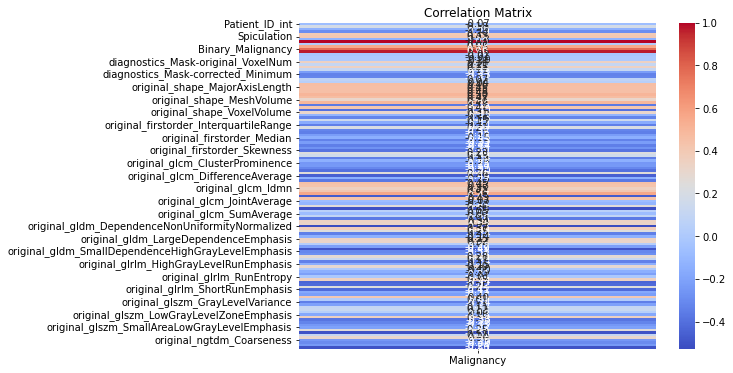

In [20]:
correlation_matrix = df_total.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix[['Malignancy']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

plt.show()

### CODE TO SPLIT DATASET INTO TRAIN/TEST WITHOUT SPLITTING NODULES OF SAME PATIENT

In [21]:
df_total.to_csv("oi.csv")
df_total = pd.read_csv("oi.csv")
splitter = GroupShuffleSplit(test_size=.20, n_splits=5, random_state = random.randint(1,1000))
split = splitter.split(df_total, groups=df_total['Patient_ID_int'])
train_inds, test_inds = next(split)

train = df_total.iloc[train_inds]
test = df_total.iloc[test_inds]

In [22]:
X_train = train.drop(['Nodule_ID', 'Malignancy', 'Binary_Malignancy', 'Normalized_Malignancy'],axis=1)
X_to_mean_train = (X_train-X_train.mean())/X_train.std() #subsitui o valor em cada célula pelo número de desvios padõres em relação à média
X_normalized_train = (X_train-X_train.min())/(X_train.max()-X_train.min())
Y_train = train['Malignancy']
Y_binary_train = train['Binary_Malignancy']
Y_normalized_train = train['Normalized_Malignancy']

X_test = test.drop(['Nodule_ID', 'Malignancy', 'Binary_Malignancy', 'Normalized_Malignancy'],axis=1)
X_to_mean_test = (X_test-X_test.mean())/X_test.std() #subsitui o valor em cada célula pelo número de desvios padõres em relação à média
X_normalized_test = (X_test-X_test.min())/(X_test.max()-X_test.min())
Y_test = test['Malignancy']
Y_binary_test = test['Binary_Malignancy']
Y_normalized_test = test['Normalized_Malignancy']

X = pd.concat([X_train,X_test])
X_to_mean = pd.concat([X_to_mean_train,X_to_mean_test])
X_normalized = pd.concat([X_normalized_train,X_normalized_test])
Y = pd.concat([Y_train,Y_test])
Y_binary = pd.concat([Y_binary_train,Y_binary_test])
Y_normalized = pd.concat([Y_normalized_train,Y_normalized_test])

In [23]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100),threshold=0.0075)
sel.fit(X_train, Y_train)


SelectFromModel(estimator=RandomForestClassifier(), threshold=0.0075)

In [24]:
sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False, False,  True,  True, False,  True, False,  True, False,
       False, False, False,  True, False, False, False, False,  True,
       False,  True,  True, False, False,  True, False, False,  True,
        True,  True,  True,  True, False, False, False,  True, False,
       False, False,  True, False,  True, False, False,  True,  True,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False,  True, False, False,  True,
       False, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False,  True, False, False,  True,  True, False, False,  True])

In [25]:
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

61

In [26]:
print(selected_feat)

Index(['Patient_ID_int', 'Subtlety', 'Sphericity', 'Margin', 'Lobulation',
       'Spiculation', 'Texture', 'Calcification',
       'diagnostics_Image-original_Mean', 'diagnostics_Image-original_Maximum',
       'diagnostics_Mask-original_VoxelNum',
       'diagnostics_Mask-corrected_VoxelNum',
       'diagnostics_Mask-corrected_Mean', 'diagnostics_Mask-corrected_Minimum',
       'diagnostics_Mask-corrected_Maximum', 'original_shape_Elongation',
       'original_shape_Flatness', 'original_shape_LeastAxisLength',
       'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume', 'original_firstorder_90Percentile',
       'o

<AxesSubplot:>

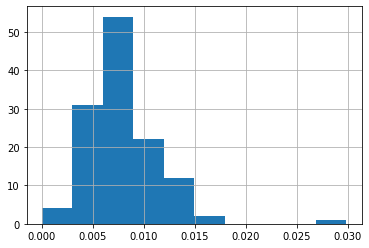

In [27]:
pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

In [28]:
X_train_trimmed = X_train[selected_feat]
X_train_trimmed['InternalStructure'] = X_train['InternalStructure']
X_test_trimmed = X_test[selected_feat]
X_test_trimmed['InternalStructure'] = X_test['InternalStructure']
X_to_mean_train_trimmed = X_to_mean_train[selected_feat]
X_to_mean_train_trimmed['InternalStructure'] = X_to_mean_train['InternalStructure']
X_to_mean_test_trimmed = X_to_mean_test[selected_feat]
X_to_mean_test_trimmed['InternalStructure'] = X_to_mean_test['InternalStructure']
X_normalized_train_trimmed = X_normalized_train[selected_feat]
X_normalized_train_trimmed['InternalStructure'] = X_normalized_train['InternalStructure']
X_normalized_test_trimmed = X_normalized_test[selected_feat]
X_normalized_test_trimmed['InternalStructure'] = X_normalized_test['InternalStructure']

C:\Users\Paulo Alexandre\AppData\Local\Temp\ipykernel_8356\351130919.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_trimmed['InternalStructure'] = X_train['InternalStructure']
C:\Users\Paulo Alexandre\AppData\Local\Temp\ipykernel_8356\351130919.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_trimmed['InternalStructure'] = X_test['InternalStructure']
C:\Users\Paulo Alexandre\AppData\Local\Temp\ipykernel_8356\351130919.py:6: SettingWithCopyWarning: 
A value is trying to be set on a cop

### KNN for normal data

Accuracy: 0.3812316715542522


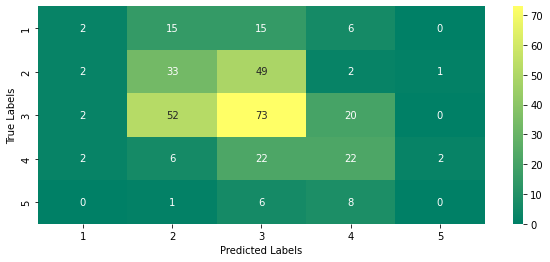

Binary Accuracy: 0.6187683284457478
Binary Precision: 0.6397849462365591
Binary Recall: 0.6538461538461539


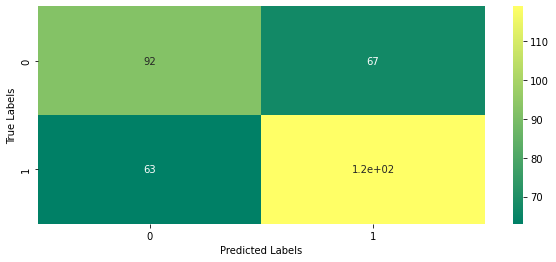

Trimmed Accuracy: 0.3782991202346041


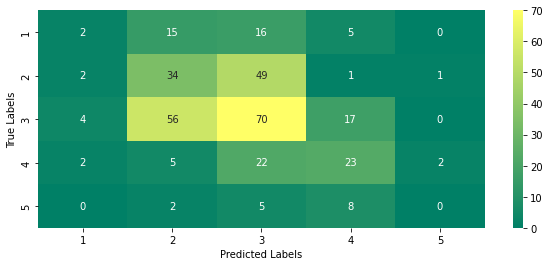

Trimmed Binary Accuracy: 0.6070381231671554
Trimmed Binary Precision: 0.6363636363636364
Trimmed Binary Recall: 0.6153846153846154


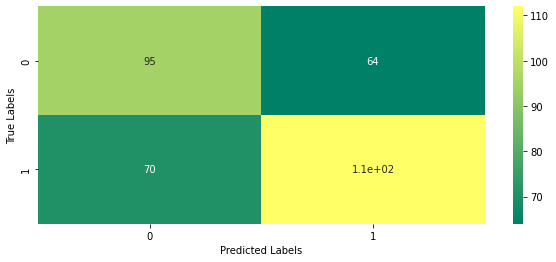

In [29]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
knn_binary = KNeighborsClassifier(n_neighbors=9)
knn_binary.fit(X_train, Y_binary_train)
Y_binary_pred = knn_binary.predict(X_test)
binary_accuracy = accuracy_score(Y_binary_test, Y_binary_pred)
print("Binary Accuracy:", binary_accuracy)
binary_precision = precision_score(Y_binary_test, Y_binary_pred)
print("Binary Precision:", binary_precision)
binary_recall = recall_score(Y_binary_test, Y_binary_pred)
print("Binary Recall:", binary_recall)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
knn_trimmed = KNeighborsClassifier(n_neighbors=9)
knn_trimmed.fit(X_train_trimmed, Y_train)
Y_pred_trimmed = knn_trimmed.predict(X_test_trimmed)
accuracy_trimmed = accuracy_score(Y_test, Y_pred_trimmed)
print("Trimmed Accuracy:", accuracy_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred_trimmed), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
knn_binary_trimmed = KNeighborsClassifier(n_neighbors=9)
knn_binary_trimmed.fit(X_train_trimmed, Y_binary_train)
Y_binary_pred_trimmed = knn_binary_trimmed.predict(X_test_trimmed)
binary_accuracy_trimmed = accuracy_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Accuracy:", binary_accuracy_trimmed)
binary_precision_trimmed = precision_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Precision:", binary_precision_trimmed)
binary_recall_trimmed = recall_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Recall:", binary_recall_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred_trimmed), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### KNN for difference to mean data

Accuracy: 0.5513196480938416


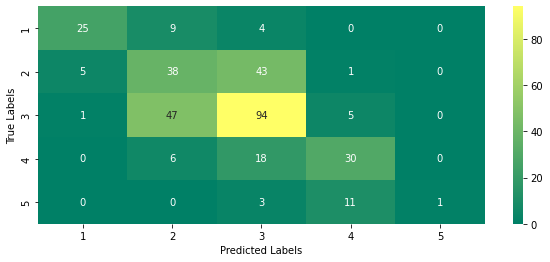

Binary Accuracy: 0.6686217008797654
Binary Precision: 0.7412587412587412
Binary Recall: 0.5824175824175825


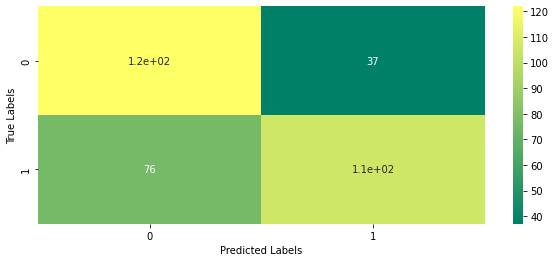

Trimmed Accuracy: 0.5630498533724341


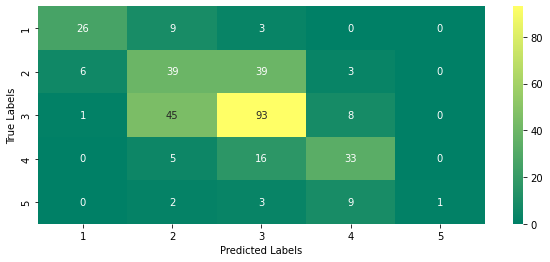

Trimmed Binary Accuracy: 0.7008797653958945
Trimmed Binary Precision: 0.7777777777777778
Trimmed Binary Recall: 0.6153846153846154


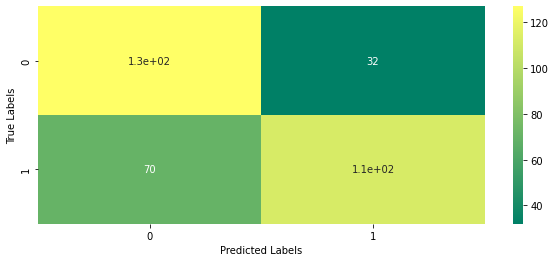

In [30]:
X_to_mean_test = X_to_mean_test.fillna(0)
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_to_mean_train, Y_train)
Y_pred = knn.predict(X_to_mean_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
knn_binary = KNeighborsClassifier(n_neighbors=9)
knn_binary.fit(X_to_mean_train, Y_binary_train)
Y_binary_pred = knn_binary.predict(X_to_mean_test)
binary_accuracy = accuracy_score(Y_binary_test, Y_binary_pred)
print("Binary Accuracy:", binary_accuracy)
binary_precision = precision_score(Y_binary_test, Y_binary_pred)
print("Binary Precision:", binary_precision)
binary_recall = recall_score(Y_binary_test, Y_binary_pred)
print("Binary Recall:", binary_recall)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
X_to_mean_test_trimmed = X_to_mean_test_trimmed.fillna(0)
knn_trimmed = KNeighborsClassifier(n_neighbors=9)
knn_trimmed.fit(X_to_mean_train_trimmed, Y_train)
Y_pred_trimmed = knn_trimmed.predict(X_to_mean_test_trimmed)
accuracy_trimmed = accuracy_score(Y_test, Y_pred_trimmed)
print("Trimmed Accuracy:", accuracy_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred_trimmed), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
knn_binary_trimmed = KNeighborsClassifier(n_neighbors=9)
knn_binary_trimmed.fit(X_to_mean_train_trimmed, Y_binary_train)
Y_binary_pred_trimmed = knn_binary_trimmed.predict(X_to_mean_test_trimmed)
binary_accuracy_trimmed = accuracy_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Accuracy:", binary_accuracy_trimmed)
binary_precision_trimmed = precision_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Precision:", binary_precision_trimmed)
binary_recall_trimmed = recall_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Recall:", binary_recall_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred_trimmed), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### KNN for normalized data

Accuracy: 0.5865102639296188


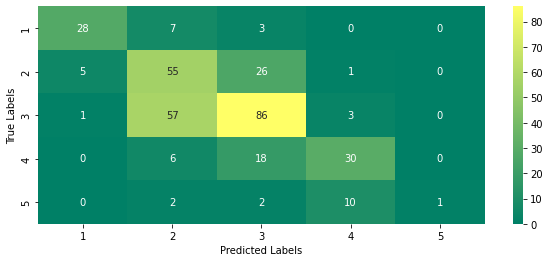

Binary Accuracy: 0.7243401759530792
Binary Precision: 0.8235294117647058
Binary Recall: 0.6153846153846154


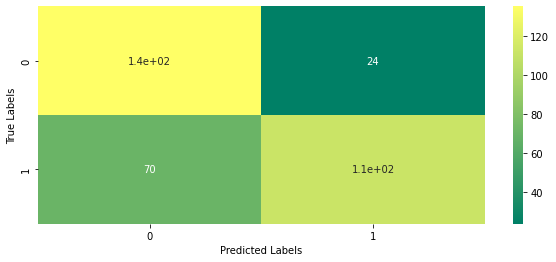

Trimmed Accuracy: 0.5571847507331378


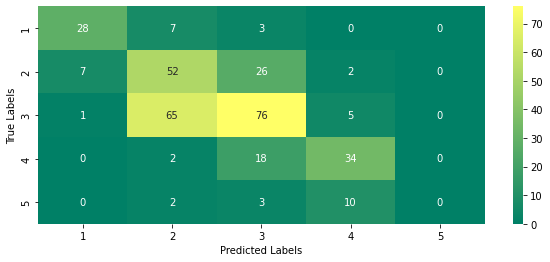

Trimmed Binary Accuracy: 0.7243401759530792
Trimmed Binary Precision: 0.8013698630136986
Trimmed Binary Recall: 0.6428571428571429


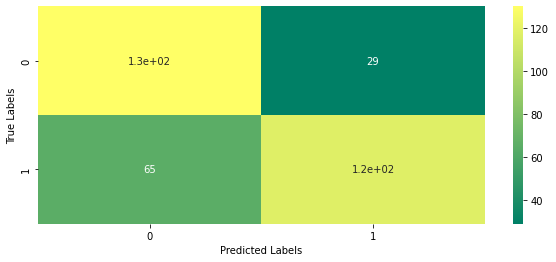

In [31]:
X_normalized_test = X_normalized_test.fillna(0.5)
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_normalized_train, Y_train)
Y_pred = knn.predict(X_normalized_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
knn_binary = KNeighborsClassifier(n_neighbors=9)
knn_binary.fit(X_normalized_train, Y_binary_train)
Y_binary_pred = knn_binary.predict(X_normalized_test)
binary_accuracy = accuracy_score(Y_binary_test, Y_binary_pred)
print("Binary Accuracy:", binary_accuracy)
binary_precision = precision_score(Y_binary_test, Y_binary_pred)
print("Binary Precision:", binary_precision)
binary_recall = recall_score(Y_binary_test, Y_binary_pred)
print("Binary Recall:", binary_recall)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
X_normalized_test_trimmed = X_normalized_test_trimmed.fillna(0.5)
knn_trimmed = KNeighborsClassifier(n_neighbors=9)
knn_trimmed.fit(X_normalized_train_trimmed, Y_train)
Y_pred_trimmed = knn_trimmed.predict(X_normalized_test_trimmed)
accuracy_trimmed = accuracy_score(Y_test, Y_pred_trimmed)
print("Trimmed Accuracy:", accuracy_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred_trimmed), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
knn_binary_trimmed = KNeighborsClassifier(n_neighbors=9)
knn_binary_trimmed.fit(X_normalized_train_trimmed, Y_binary_train)
Y_binary_pred_trimmed = knn_binary_trimmed.predict(X_normalized_test_trimmed)
binary_accuracy_trimmed = accuracy_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Accuracy:", binary_accuracy_trimmed)
binary_precision_trimmed = precision_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Precision:", binary_precision_trimmed)
binary_recall_trimmed = recall_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Recall:", binary_recall_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred_trimmed), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### SVM for normal data

In [32]:
# THIS WILL TAKE A REALLY LONG TIME, FOR BETTER PERFOMANCE USE DIFFERENTLY TREATED DATA

'''
Svm = svm.SVC(kernel='linear')
Svm.fit(X_train, Y_train)
Y_pred = Svm.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
svm_binary = svm.SVC(kernel='linear')
svm_binary.fit(X_train, Y_binary_train)
Y_binary_pred = svm_binary.predict(X_test)
binary_accuracy = accuracy_score(Y_binary_test, Y_binary_pred)
print("Binary Accuracy:", binary_accuracy)
binary_precision = precision_score(Y_binary_test, Y_binary_pred)
print("Binary Precision:", binary_precision)
binary_recall = recall_score(Y_binary_test, Y_binary_pred)
print("Binary Recall:", binary_recall)
Svm_trimmed = svm.SVC(kernel='linear')
Svm_trimmed.fit(X_train_trimmed, Y_train)
Y_pred_trimmed = Svm.predict(X_test_trimmed)
accuracy_trimmed = accuracy_score(Y_test, Y_pred_trimmed)
print("Trimmed Accuracy:", accuracy_trimmed)
svm_binary_trimmed = svm.SVC(kernel='linear')
svm_binary_trimmed.fit(X_train_trimmed, Y_binary_train)
Y_binary_pred_trimmed = svm_binary_trimmed.predict(X_test_trimmed)
binary_accuracy_trimmed = accuracy_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Accuracy:", binary_accuracy_trimmed)
binary_precision_trimmed = precision_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Precision:", binary_precision_trimmed)
binary_recall_trimmed = recall_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Recall:", binary_recall_trimmed)
'''

'\nSvm = svm.SVC(kernel=\'linear\')\nSvm.fit(X_train, Y_train)\nY_pred = Svm.predict(X_test)\naccuracy = accuracy_score(Y_test, Y_pred)\nprint("Accuracy:", accuracy)\nsvm_binary = svm.SVC(kernel=\'linear\')\nsvm_binary.fit(X_train, Y_binary_train)\nY_binary_pred = svm_binary.predict(X_test)\nbinary_accuracy = accuracy_score(Y_binary_test, Y_binary_pred)\nprint("Binary Accuracy:", binary_accuracy)\nbinary_precision = precision_score(Y_binary_test, Y_binary_pred)\nprint("Binary Precision:", binary_precision)\nbinary_recall = recall_score(Y_binary_test, Y_binary_pred)\nprint("Binary Recall:", binary_recall)\nSvm_trimmed = svm.SVC(kernel=\'linear\')\nSvm_trimmed.fit(X_train_trimmed, Y_train)\nY_pred_trimmed = Svm.predict(X_test_trimmed)\naccuracy_trimmed = accuracy_score(Y_test, Y_pred_trimmed)\nprint("Trimmed Accuracy:", accuracy_trimmed)\nsvm_binary_trimmed = svm.SVC(kernel=\'linear\')\nsvm_binary_trimmed.fit(X_train_trimmed, Y_binary_train)\nY_binary_pred_trimmed = svm_binary_trimmed.pr

### SVM for difference to mean data

Accuracy: 0.5806451612903226


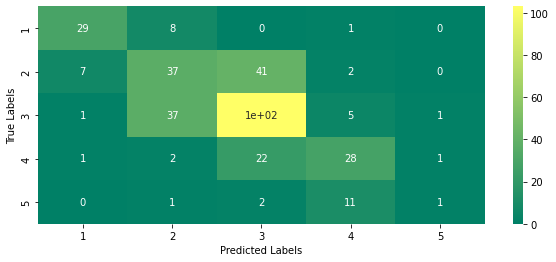

Binary Accuracy: 0.7448680351906158
Binary Precision: 0.8064516129032258
Binary Recall: 0.6868131868131868


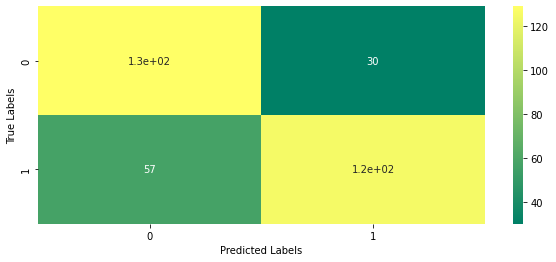

Trimmed Accuracy: 0.5747800586510264


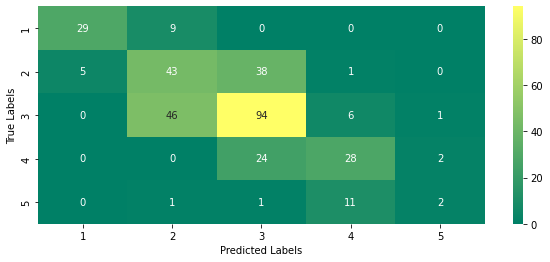

Trimmed Binary Accuracy: 0.7536656891495601
Trimmed Binary Precision: 0.8266666666666667
Trimmed Binary Recall: 0.6813186813186813


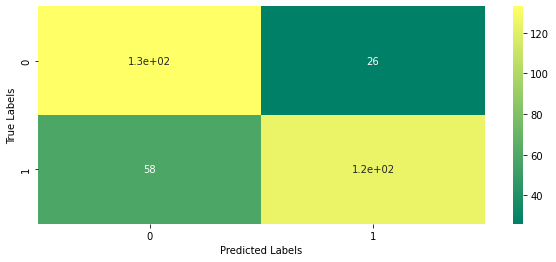

In [33]:
X_to_mean_test = X_to_mean_test.fillna(0.5)
Svm = svm.SVC(kernel='linear')
Svm.fit(X_to_mean_train, Y_train)
Y_pred = Svm.predict(X_to_mean_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
svm_binary = svm.SVC(kernel='linear')
svm_binary.fit(X_to_mean_train, Y_binary_train)
Y_binary_pred = svm_binary.predict(X_to_mean_test)
binary_accuracy = accuracy_score(Y_binary_test, Y_binary_pred)
print("Binary Accuracy:", binary_accuracy)
binary_precision = precision_score(Y_binary_test, Y_binary_pred)
print("Binary Precision:", binary_precision)
binary_recall = recall_score(Y_binary_test, Y_binary_pred)
print("Binary Recall:", binary_recall)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
X_to_mean_test_trimmed = X_to_mean_test_trimmed.fillna(0.5)
Svm_trimmed = svm.SVC(kernel='linear')
Svm_trimmed.fit(X_to_mean_train_trimmed, Y_train)
Y_pred_trimmed = Svm_trimmed.predict(X_to_mean_test_trimmed)
accuracy_trimmed = accuracy_score(Y_test, Y_pred_trimmed)
print("Trimmed Accuracy:", accuracy_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred_trimmed), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
svm_binary_trimmed = svm.SVC(kernel='linear')
svm_binary_trimmed.fit(X_to_mean_train_trimmed, Y_binary_train)
Y_binary_pred_trimmed = svm_binary_trimmed.predict(X_to_mean_test_trimmed)
binary_accuracy_trimmed = accuracy_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Accuracy:", binary_accuracy_trimmed)
binary_precision_trimmed = precision_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Precision:", binary_precision_trimmed)
binary_recall_trimmed = recall_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Recall:", binary_recall_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred_trimmed), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### SVM for normalized data

Accuracy: 0.6158357771260997


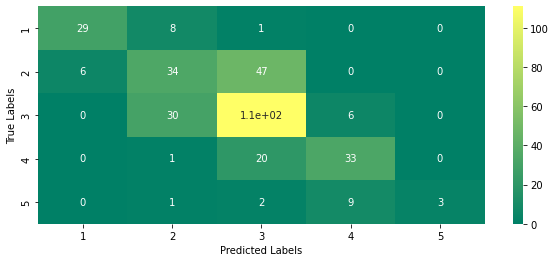

Binary Accuracy: 0.750733137829912
Binary Precision: 0.7437185929648241
Binary Recall: 0.8131868131868132


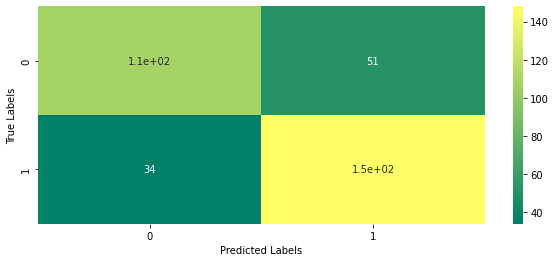

Trimmed Accuracy: 0.5865102639296188


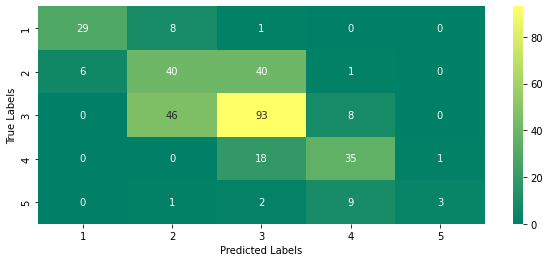

Trimmed Binary Accuracy: 0.718475073313783
Trimmed Binary Precision: 0.7009345794392523
Trimmed Binary Recall: 0.8241758241758241


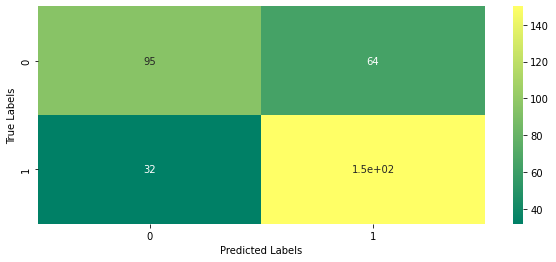

In [34]:
X_normalized_test = X_normalized_test.fillna(0.5)
Svm = svm.SVC(kernel='linear')
Svm.fit(X_normalized_train, Y_train)
Y_pred = Svm.predict(X_normalized_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
svm_binary = svm.SVC(kernel='linear')
svm_binary.fit(X_normalized_train, Y_binary_train)
Y_binary_pred = svm_binary.predict(X_normalized_test)
binary_accuracy = accuracy_score(Y_binary_test, Y_binary_pred)
print("Binary Accuracy:", binary_accuracy)
binary_precision = precision_score(Y_binary_test, Y_binary_pred)
print("Binary Precision:", binary_precision)
binary_recall = recall_score(Y_binary_test, Y_binary_pred)
print("Binary Recall:", binary_recall)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
X_normalized_test_trimmed = X_normalized_test_trimmed.fillna(0.5)
Svm_trimmed = svm.SVC(kernel='linear')
Svm_trimmed.fit(X_normalized_train_trimmed, Y_train)
Y_pred_trimmed = Svm_trimmed.predict(X_normalized_test_trimmed)
accuracy_trimmed = accuracy_score(Y_test, Y_pred_trimmed)
print("Trimmed Accuracy:", accuracy_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred_trimmed), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
svm_binary_trimmed = svm.SVC(kernel='linear')
svm_binary_trimmed.fit(X_normalized_train_trimmed, Y_binary_train)
Y_binary_pred_trimmed = svm_binary_trimmed.predict(X_normalized_test_trimmed)
binary_accuracy_trimmed = accuracy_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Accuracy:", binary_accuracy_trimmed)
binary_precision_trimmed = precision_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Precision:", binary_precision_trimmed)
binary_recall_trimmed = recall_score(Y_binary_test, Y_binary_pred_trimmed)
print("Trimmed Binary Recall:", binary_recall_trimmed)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred_trimmed), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [35]:
def majorityvote(d):
    for i in range(len(d)):
        max = 0
        maxc = -1
        for c in d.columns:
            if d.iloc[i][c]>max:
                max = d.iloc[i][c]
                maxc = c
        for c in d.columns:
            if c == maxc:
                d.iloc[i][c] = int(1)
            else:
                d.iloc[i][c] = int(0)

def turnint(d):
    for i in range(len(d)):
        for c in d.columns:
            d.iloc[i][c] = int(d.iloc[i][c]+1)

def round_binary(d):
    for i in range(len(d)):
        for c in d.columns:
            d.iloc[i][c] = round(d.iloc[i][c])

### Neural Network for normal data

In [36]:
X_train_tf = X_train.values
X_test_tf = X_test.values
Y_train_tf = pd.get_dummies(Y_train)
Y_train_tf = Y_train_tf.values
Y_test_dummies = pd.get_dummies(Y_test)
Y_test_tf = Y_test_dummies.values
model = Sequential([Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(5, activation='softmax')])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mse'])
history = model.fit(X_train_tf,Y_train_tf,validation_data = (X_test_tf,Y_test_tf), epochs=30,verbose=0)
Y_pred = model.predict(X_test_tf)
Y_pred = pd.DataFrame(Y_pred)
majorityvote(Y_pred)
Y_pred = pd.from_dummies(Y_pred)
turnint(Y_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['mse', 'val_mse']].plot(title="Accuracy")

Y_binary_train_tf = Y_binary_train.values
Y_binary_test_tf = Y_binary_test.values
model_binary = Sequential([Dense(500, activation='relu'),Dense(1, activation='sigmoid')])
model_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
history_binary = model_binary.fit(X_train_tf,Y_binary_train_tf,validation_data = (X_test_tf,Y_binary_test_tf), epochs=30,verbose=0)
Y_binary_pred = model_binary.predict(X_test_tf)
Y_binary_pred = pd.DataFrame(Y_binary_pred)
round_binary(Y_binary_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy_binary = accuracy_score(Y_binary_test, Y_binary_pred)
print("Accuracy:", accuracy_binary)
history_binary_df = pd.DataFrame(history_binary.history)
history_binary_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_binary_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

11/11 [==============================] - 0s 6ms/step


AttributeError: module 'pandas' has no attribute 'from_dummies'

### Neural Network for difference to mean data

12/12 [==============================] - 0s 6ms/step


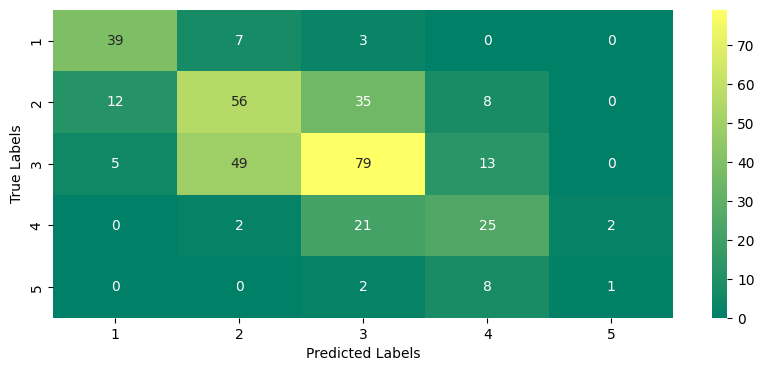

Accuracy: 0.5449591280653951
12/12 [==============================] - 0s 2ms/step


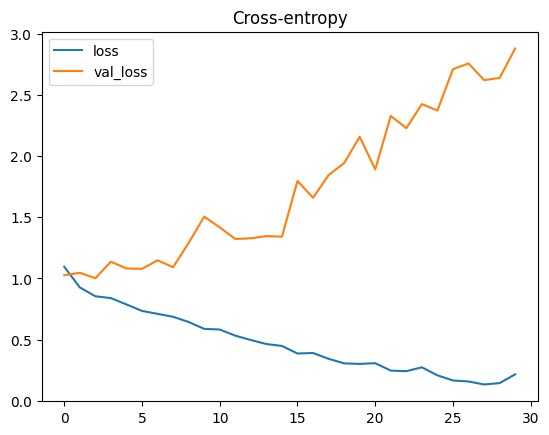

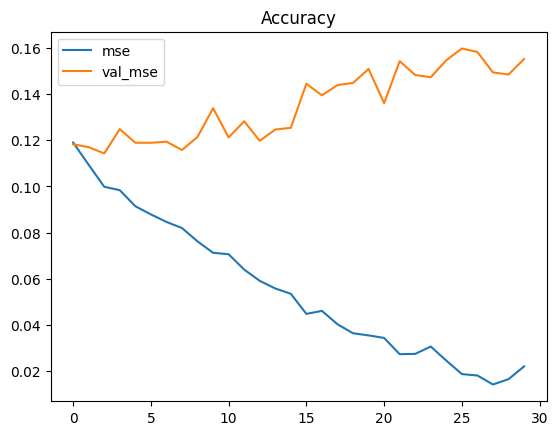

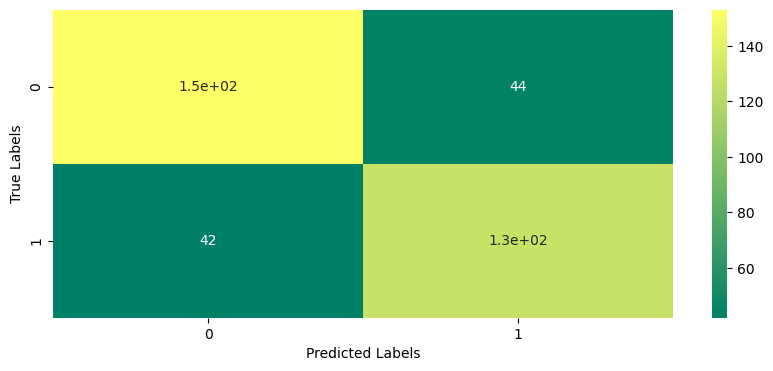

Accuracy: 0.7656675749318801


<Axes: title={'center': 'Accuracy'}>

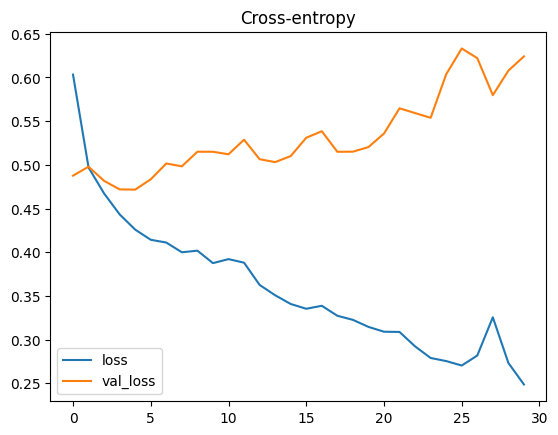

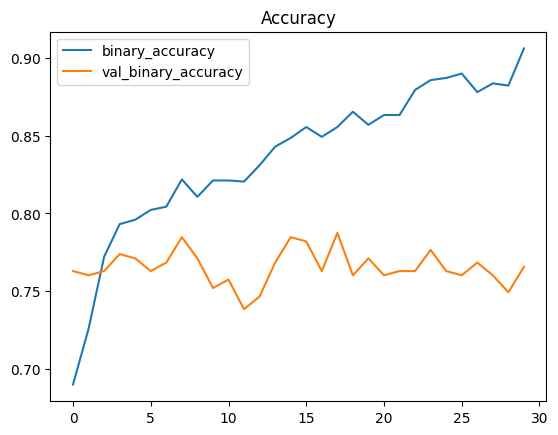

In [ ]:
X_to_mean_train_tf = X_to_mean_train.values
X_to_mean_test_tf = X_to_mean_test.values
Y_train_tf = pd.get_dummies(Y_train)
Y_train_tf = Y_train_tf.values
Y_test_dummies = pd.get_dummies(Y_test)
Y_test_tf = Y_test_dummies.values
model = Sequential([Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(5, activation='softmax')])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mse'])
history = model.fit(X_to_mean_train_tf,Y_train_tf,validation_data = (X_to_mean_test_tf,Y_test_tf), epochs=30,verbose=0)
Y_pred = model.predict(X_to_mean_test_tf)
Y_pred = pd.DataFrame(Y_pred)
majorityvote(Y_pred)
Y_pred = pd.from_dummies(Y_pred)
turnint(Y_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['mse', 'val_mse']].plot(title="Accuracy")

Y_binary_train_tf = Y_binary_train.values
Y_binary_test_tf = Y_binary_test.values
model_binary = Sequential([Dense(500, activation='relu'),Dense(1, activation='sigmoid')])
model_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
history_binary = model_binary.fit(X_to_mean_train_tf,Y_binary_train_tf,validation_data = (X_to_mean_test_tf,Y_binary_test_tf), epochs=30,verbose=0)
Y_binary_pred = model_binary.predict(X_to_mean_test_tf)
Y_binary_pred = pd.DataFrame(Y_binary_pred)
round_binary(Y_binary_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy_binary = accuracy_score(Y_binary_test, Y_binary_pred)
print("Accuracy:", accuracy_binary)
history_binary_df = pd.DataFrame(history_binary.history)
history_binary_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_binary_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

### Neural Network for normalized data

12/12 [==============================] - 0s 6ms/step


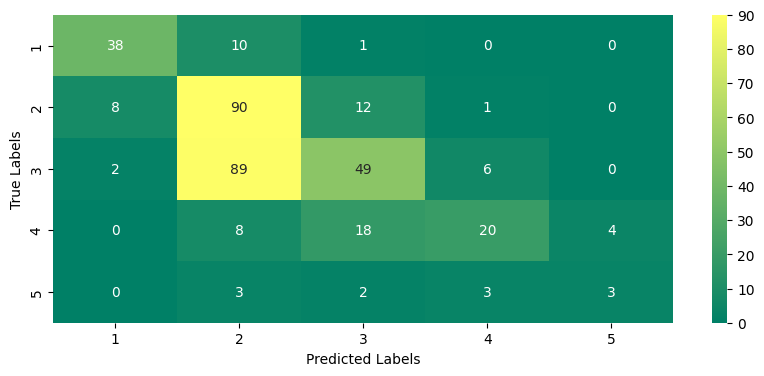

Accuracy: 0.5449591280653951
12/12 [==============================] - 0s 2ms/step


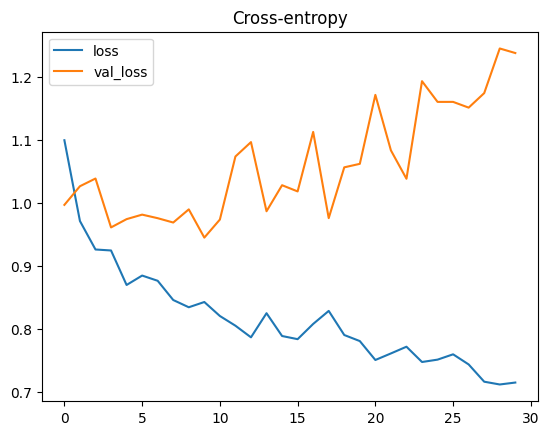

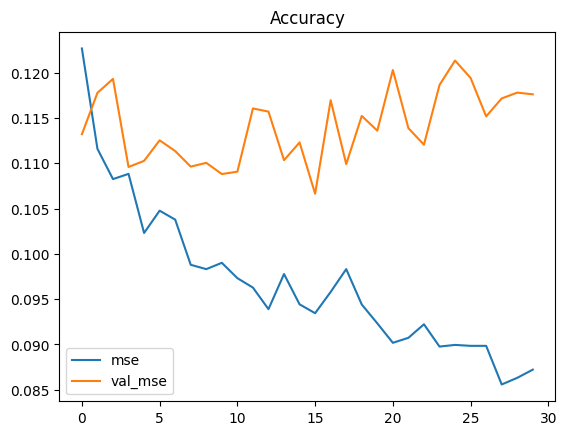

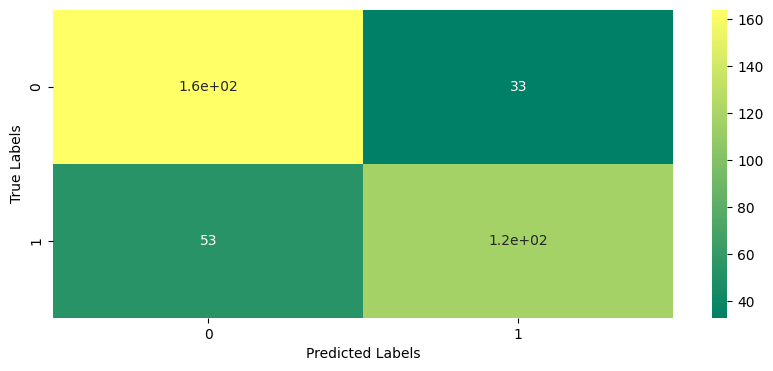

Accuracy: 0.7656675749318801


<Axes: title={'center': 'Accuracy'}>

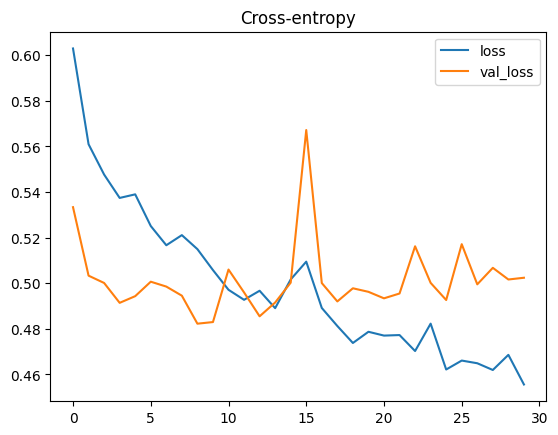

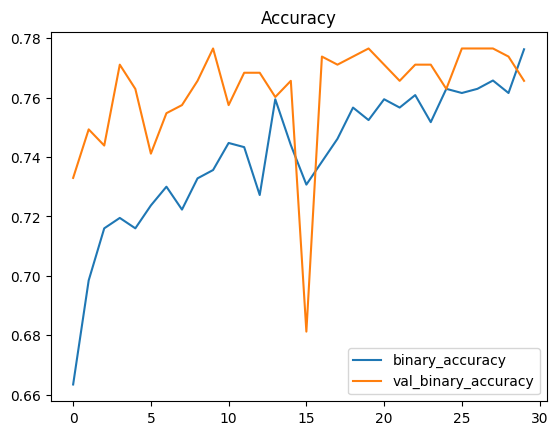

In [ ]:
X_normalized_train_tf = X_normalized_train.values
X_normalized_test_tf = X_normalized_test.values
Y_train_tf = pd.get_dummies(Y_train)
Y_train_tf = Y_train_tf.values
Y_test_dummies = pd.get_dummies(Y_test)
Y_test_tf = Y_test_dummies.values
model = Sequential([Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(5, activation='softmax')])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mse'])
history = model.fit(X_normalized_train_tf,Y_train_tf,validation_data = (X_normalized_test_tf,Y_test_tf), epochs=30,verbose=0)
Y_pred = model.predict(X_normalized_test_tf)
Y_pred = pd.DataFrame(Y_pred)
majorityvote(Y_pred)
Y_pred = pd.from_dummies(Y_pred)
turnint(Y_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['mse', 'val_mse']].plot(title="Accuracy")

Y_binary_train_tf = Y_binary_train.values
Y_binary_test_tf = Y_binary_test.values
model_binary = Sequential([Dense(500, activation='relu'),Dense(1, activation='sigmoid')])
model_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
history_binary = model_binary.fit(X_normalized_train_tf,Y_binary_train_tf,validation_data = (X_normalized_test_tf,Y_binary_test_tf), epochs=30,verbose=0)
Y_binary_pred = model_binary.predict(X_normalized_test_tf)
Y_binary_pred = pd.DataFrame(Y_binary_pred)
round_binary(Y_binary_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy_binary = accuracy_score(Y_binary_test, Y_binary_pred)
print("Accuracy:", accuracy_binary)
history_binary_df = pd.DataFrame(history_binary.history)
history_binary_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_binary_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

# Neural Network for trimmed data

In [ ]:
X_trimmed_train_tf = X_train_trimmed.values
X_trimmed_test_tf = X_test_trimmed.values
Y_train_tf = pd.get_dummies(Y_train)
Y_train_tf = Y_train_tf.values
Y_test_dummies = pd.get_dummies(Y_test)
Y_test_tf = Y_test_dummies.values
model = Sequential([Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(500, activation='relu'),Dense(5, activation='softmax')])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mse'])
history = model.fit(X_trimmed_train_tf,Y_train_tf,validation_data = (X_trimmed_test_tf,Y_test_tf), epochs=30,verbose=0)
Y_pred = model.predict(X_trimmed_test_tf)
Y_pred = pd.DataFrame(Y_pred)
majorityvote(Y_pred)
Y_pred = pd.from_dummies(Y_pred)
turnint(Y_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_test, Y_pred), annot = True, xticklabels = [1,2,3,4,5], yticklabels = [1,2,3,4,5], cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['mse', 'val_mse']].plot(title="Accuracy")

Y_binary_train_tf = Y_binary_train.values
Y_binary_test_tf = Y_binary_test.values
model_binary = Sequential([Dense(500, activation='relu'),Dense(1, activation='sigmoid')])
model_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
history_binary = model_binary.fit(X_trimmed_train_tf,Y_binary_train_tf,validation_data = (X_trimmed_test_tf,Y_binary_test_tf), epochs=30,verbose=0)
Y_binary_pred = model_binary.predict(X_trimmed_test_tf)
Y_binary_pred = pd.DataFrame(Y_binary_pred)
round_binary(Y_binary_pred)
plt.figure(figsize = (10,4))
sns.heatmap(metricssk.confusion_matrix(Y_binary_test, Y_binary_pred), annot = True, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
accuracy_binary = accuracy_score(Y_binary_test, Y_binary_pred)
print("Accuracy:", accuracy_binary)
history_binary_df = pd.DataFrame(history_binary.history)
history_binary_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_binary_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")